# 目的：MNISTのFashion画像を予測し、予測結果を提出する

# 0ライブラリ読み込み

In [ ]:
!pip install -q pytorch_lightning
!pip install -q torchmetrics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms#tensor型にしてくれる
from torchvision import datasets

In [ ]:
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger

# 1データ読み込み

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_val = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test = datasets.FashionMNIST('./', train=False, download=True, transform=transform)

In [ ]:
test[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_val

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

# 2データ概要

# 3データ前処理

# 4データ分析

# 5tensor型、datasets、ホールドアウト法、dataloader

In [ ]:
n_train=50000
n_val = 10000

In [ ]:
pl.seed_everything(0)
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

INFO:lightning_fabric.utilities.seed:Seed set to 0


In [ ]:
#dataloader
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train,batch_size,shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# 6ネットワークモデル構築

In [ ]:
aftersize=3*3*64
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        #self.bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        #self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(aftersize,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        h = self.conv(x)
        h = F.relu(h)
        #h = self.bn(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        #h = self.bn2(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv3(h)
        h = F.relu(h)
        #h = self.bn3(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = h.view(-1, aftersize)
        h = self.fc(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=10, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=10, top_k=1), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.log("test_acc", accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=10, top_k=1), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer

In [ ]:
net = Net().cuda()
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                   [-1, 64]          36,928
            Linear-5                   [-1, 10]             650
Total params: 93,322
Trainable params: 93,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.36
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


# 7ネットワークモデル学習

In [ ]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir="logs", name="my_exp")
trainer = pl.Trainer(max_epochs=30, accelerator= "gpu", deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | conv  | Conv2d | 320   
1 | conv2 | Conv2d | 18.5 K
2 | conv3 | Conv2d | 36.9 K
3 | fc    | Linear | 36.9 K
4 | fc2   | Linear | 650   
---------------------------------
93.3 K    Trainable params
0         Non-trainable params
93.3 K    Total params
0.373     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# 8性能評価

In [ ]:
trainer.callback_metrics

{'train_loss': tensor(0.0810),
 'train_loss_step': tensor(0.1060),
 'train_acc': tensor(0.9694),
 'train_acc_step': tensor(0.9600),
 'val_loss': tensor(0.3276),
 'val_acc': tensor(0.9080),
 'train_loss_epoch': tensor(0.0810),
 'train_acc_epoch': tensor(0.9694)}

In [ ]:
log = pd.read_csv("/content/logs/my_exp/version_7/metrics.csv")

In [ ]:
log

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
0,0,47,NaN,NaN,NaN,NaN,NaN,NaN,0.6732,1.360114
1,0,47,NaN,NaN,0.588175,NaN,1.410065,NaN,NaN,NaN
2,1,49,NaN,NaN,NaN,0.762695,NaN,0.883143,NaN,NaN
3,1,95,NaN,NaN,NaN,NaN,NaN,NaN,0.7925,0.649180
4,1,95,NaN,NaN,0.780924,NaN,0.735322,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
84,28,1391,NaN,NaN,0.933105,NaN,0.195940,NaN,NaN,NaN
85,29,1399,NaN,NaN,NaN,0.934570,NaN,0.193088,NaN,NaN
86,29,1439,NaN,NaN,NaN,NaN,NaN,NaN,0.8977,0.285820
87,29,1439,NaN,NaN,0.936198,NaN,0.188451,NaN,NaN,NaN


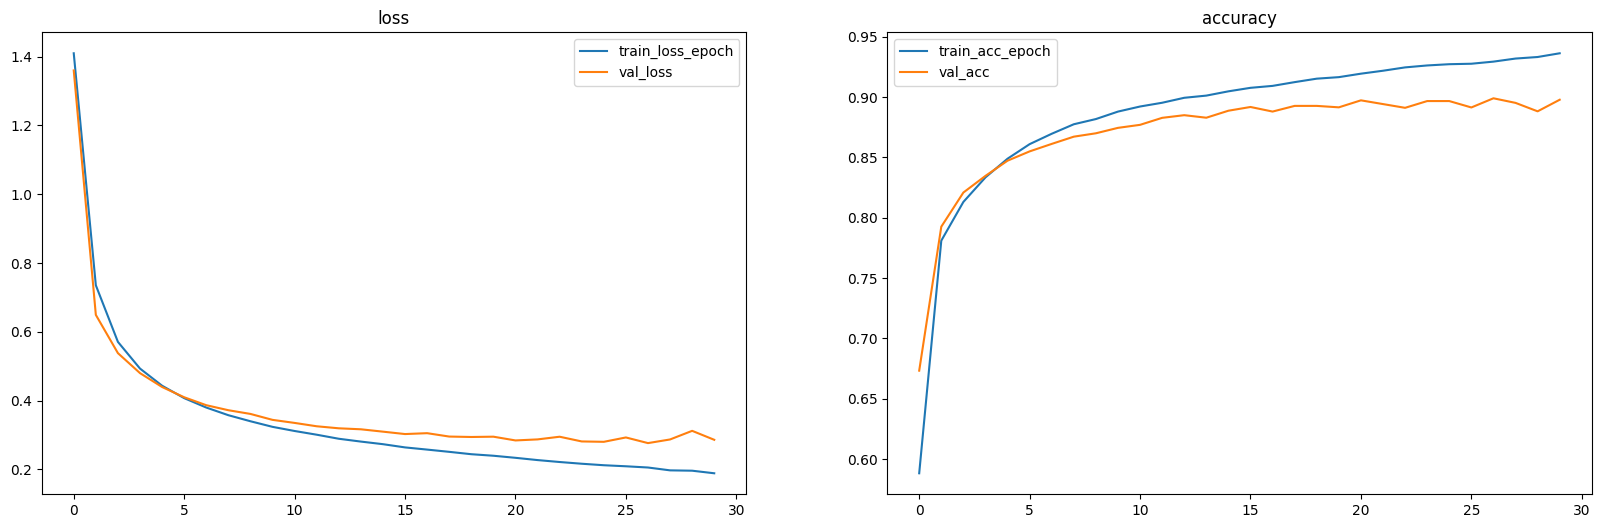

In [ ]:
#学習の過程を見る
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
log[["train_loss_epoch", "epoch"]].dropna(how="any", axis=0).reset_index()["train_loss_epoch"].plot();
log[["val_loss", "epoch"]].dropna(how="any", axis=0).reset_index()["val_loss"].plot();
plt.title("loss")
plt.legend();

plt.subplot(1,2,2)
log[["train_acc_epoch", "epoch"]].dropna(how="any", axis=0).reset_index()["train_acc_epoch"].plot();
log[["val_acc", "epoch"]].dropna(how="any", axis=0).reset_index()["val_acc"].plot();
plt.title("accuracy")
plt.legend();

In [ ]:
#テストデータを試す
trainer.test(dataloaders = test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_11/checkpoints/epoch=29-step=1440.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/my_exp/version_11/checkpoints/epoch=29-step=1440.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9061999917030334     │
│         test_loss         │    0.3429102897644043     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3429102897644043, 'test_acc': 0.9061999917030334}]

# 9学習したモデルの保存

In [ ]:
torch.save(net.state_dict(), "pytorch09.pt")

# 10学習したモデルで推論

In [ ]:
#net.eval()

In [ ]:
predictions=[]
with torch.no_grad():
    for images, _ in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)#最大値と最大値のインデックスを返り値として出力する
        predictions.extend(predicted.tolist())
print(predictions)

[9, 2, 1, 1, 6, 1, 2, 6, 5, 7, 4, 5, 7, 3, 2, 1, 2, 6, 8, 0, 2, 5, 7, 5, 1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 3, 6, 7, 1, 8, 0, 1, 2, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 3, 4, 1, 3, 5, 2, 6, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 9, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 6, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 2, 8, 6, 2, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 6, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 4, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 6, 2, 4, 7, 1, 6, 4, 8, 2, 6, 5, 6, 6, 7, 7, 7, 3, 3, 7, 3, 

# 11推論値をCSVで保存する

In [ ]:
pd.Series(predictions, name="class").to_csv("submission.csv", index=None)